# LSTM Assignment

In [7]:
#importing the required libraries
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd
import sqlite3
import nltk
import re
import pickle
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
import string
from prettytable import PrettyTable
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)
nltk.download('stopwords')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (10000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [10]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [11]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [12]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [15]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9564, 10)

In [16]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.64

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [17]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [19]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(9564, 10)


1    7976
0    1588
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [20]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
15 month old loves to eat them on the go! They seem great for a healthy, quick, and easy snack!
These chips are truly amazing. They have it all. They're light, crisp, great tasting, nice texture, AND they're all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and couldn't belive my taste buds. That's why I excited why I saw them here on Amazon, and decided to buy a case!
These tablets definitely made things sweeter -- like lemons, limes, and grapefruit.  But it wasn't to the point of sheer amazement.  They also had an interesting effect on cheeses and vinegar, but still did virtually nothing for beer and wine. The tablets are a bit pricey but they do work.  If you've got extra money, sure, give them a try, but if you're looking for some amazing way to get your kids to eat broccoli or something along those lines then this is not the answer. F

In [21]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [22]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
15 month old loves to eat them on the go! They seem great for a healthy, quick, and easy snack!
These chips are truly amazing. They have it all. They're light, crisp, great tasting, nice texture, AND they're all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and couldn't belive my taste buds. That's why I excited why I saw them here on Amazon, and decided to buy a case!
These tablets definitely made things sweeter -- like lemons, limes, and grapefruit.  But it wasn't to the point of sheer amazement.  They also had an interesting effect on cheeses and vinegar, but still did virtually nothing for beer and wine. The tablets are a bit pricey but they do work.  If you've got extra money, sure, give them a try, but if you're looking for some amazing way to get your kids to eat broccoli or something along those lines then this is not the answer. F

In [0]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [24]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

These chips are truly amazing. They have it all. They are light, crisp, great tasting, nice texture, AND they are all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and could not belive my taste buds. That is why I excited why I saw them here on Amazon, and decided to buy a case!


In [25]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

These chips are truly amazing. They have it all. They are light, crisp, great tasting, nice texture, AND they are all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and could not belive my taste buds. That is why I excited why I saw them here on Amazon, and decided to buy a case!


In [26]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [27]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

These chips are truly amazing They have it all They are light crisp great tasting nice texture AND they are all natural AND low in fat and sodium Need I say more I recently bought a bag of them at a regular grocery store and could not belive my taste buds That is why I excited why I saw them here on Amazon and decided to buy a case 


In [32]:
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    #sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 9564/9564 [00:03<00:00, 2454.08it/s]


In [33]:
preprocessed_reviews[1500]

'These chips are truly amazing They have it all They are light crisp great tasting nice texture AND they are all natural AND low in fat and sodium Need I say more I recently bought a bag of them at a regular grocery store and could not belive my taste buds That is why I excited why I saw them here on Amazon and decided to buy a case'

In [34]:
#scores = final['Score'].get_values()
li = lambda x: 1 if x=='positive'  else 0
final_scores = []
for i in tqdm(final['Score'].values):
    final_scores.append(li(i))
final_scores = np.asarray(final_scores)
final_scores.shape

100%|██████████| 9564/9564 [00:00<00:00, 402285.73it/s]


(9564,)

## Getting the vocabulary.

In [35]:
j = []
for i in tqdm(preprocessed_reviews):
  i = i.split()
  for k in i:
    j.append(k)

100%|██████████| 9564/9564 [00:00<00:00, 57165.22it/s]


In [36]:
j = set(j)
j = list(j)
len(j)

23507

### From the above result we can see that there are 23507 unique words in preprocessed reviews.

## Getting the frequency of every word.

In [37]:
word_freq = {}
a = 0
list_of_words_dict = {j[i]:j[i] for i in range(len(j))}
#preprocessed_reviews_dict = {preprocessed_reviews[i]: preprocessed_reviews[i] for i in range(len(preprocessed_reviews))}
for i in tqdm(list_of_words_dict.keys()):
  for k in preprocessed_reviews:
    k = k.split()
    if list_of_words_dict[i] not in k:
      continue
    else:
      a += 1
  word_freq.update({list_of_words_dict[i]: a})
  a=0

100%|██████████| 23507/23507 [20:29<00:00, 18.98it/s]


### Sorting the words according to frequency in descending order.

In [0]:
from operator import itemgetter
sorted_word_freq_list = sorted(word_freq.items(), key=itemgetter(1), reverse=True)

In [39]:
type(sorted_word_freq_list)

list

In [40]:
word_freq = {}
for i in tqdm(sorted_word_freq_list):
  word_freq.update({i[0]: i[1]})

100%|██████████| 23507/23507 [00:00<00:00, 802757.71it/s]


### Creating a list of all words in order they occur in word_freq dictionary above.

In [0]:
word_freq_list = []
for i in word_freq.keys():
  word_freq_list.append(i)

### Now representing every review in preprocessed_reviews as numerical vector.

In [0]:
preprocessed_vectors = []
for i in preprocessed_reviews:
  i = i.split()
  a = []
  for j in i:
      k = word_freq_list.index(j)
      a.append(k+1)
 # a = np.asarray(a)
  preprocessed_vectors.append(a)

In [43]:
len(preprocessed_vectors)

9564

### Padding every reviews to length 600

In [0]:
max_review_length = 600
preprocessed_vectors = sequence.pad_sequences(preprocessed_vectors, maxlen=max_review_length)

### Now dividing the dataset into train and test sets.

In [0]:
X_train = preprocessed_vectors[0: 8500]
y_train = final_scores[0: 8500]

In [0]:
X_test = preprocessed_vectors[8500: ]
y_test = final_scores[8500: ]

# Training 2 different models.

### Creating a model with two LSTM layers with a dropout layer between them of value 0.2 and two dense layers with tanh and sigmoidal activation functions and with RMS prop optimizer.

In [51]:
embedding_vector_length = 64
model = Sequential()
model.add(Embedding(23507, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(128, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 64)           1504448   
_________________________________________________________________
lstm_3 (LSTM)                (None, 600, 50)           23000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 600, 50)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               6528      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,554,305
Trainable params: 1,554,305
Non-trainable params: 0
_________________________________________________________________


In [52]:
history=model.fit(X_train, y_train, nb_epoch=10, batch_size=32, validation_data=(X_test, y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 8500 samples, validate on 1064 samples
Epoch 1/10
8500/8500 [==============================] - 619s 73ms/step - loss: 0.0102 - acc: 0.9974 - val_loss: 1.0076e-07 - val_acc: 1.0000
Epoch 2/10
8500/8500 [==============================] - 613s 72ms/step - loss: 1.0050e-07 - acc: 1.0000 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 3/10
8500/8500 [==============================] - 613s 72ms/step - loss: 1.0005e-07 - acc: 1.0000 - val_loss: 1.0002e-07 - val_acc: 1.0000
Epoch 4/10
8500/8500 [==============================] - 610s 72ms/step - loss: 1.0002e-07 - acc: 1.0000 - val_loss: 1.0002e-07 - val_acc: 1.0000
Epoch 5/10
8500/8500 [==============================] - 605s 71ms/step - loss: 1.0003e-07 - acc: 1.0000 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 6/10
8500/8500 [==============================] - 611s 72ms/step - loss: 1.0001e-07 - acc: 1.0000 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 7/10
8500/8500 [==============================] - 608s 71ms/step - loss: 1.0001e

In [53]:
print(history.history['loss'])
print(history.history['acc'])
print(history.history['val_loss'])
print(history.history['val_acc'])

[0.010208155558105418, 1.0050140055869526e-07, 1.0005292358528095e-07, 1.0002058711640584e-07, 1.0002838049625579e-07, 1.0001131489817078e-07, 1.0001357480525579e-07, 1.0002035455326062e-07, 1.0001809461942577e-07, 1.0001357480525579e-07]
[0.9974117647058823, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0076385058340734e-07, 1.0000001537946446e-07, 1.0001806914847054e-07, 1.0001806914847054e-07, 1.0000001537946446e-07, 1.0000001537946446e-07, 1.0001806914847054e-07, 1.0000001537946446e-07, 1.0000001537946446e-07, 1.0000001537946446e-07]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Test score: 1.0000001537946446e-07
Test accuracy: 1.0


Text(0, 0.5, 'Categorical Crossentropy Loss')

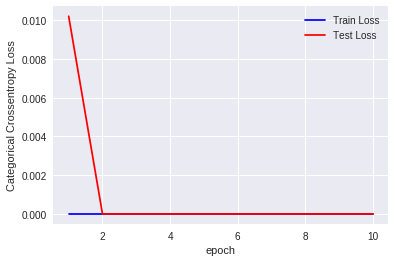

In [54]:
#score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])
nb_epoch =10
import matplotlib.pyplot as plt
import numpy as np
import time
plt.plot(list(range(1,nb_epoch+1)), history.history['val_loss'], 'b', label="Train Loss")
plt.plot(list(range(1,nb_epoch+1)), history.history['loss'], 'r', label="Test Loss")
plt.legend()
plt.xlabel('epoch') ; plt.ylabel('Categorical Crossentropy Loss')

### Creating a model with two LSTM layers with 100 units each and two dense layer with no dropout and adam optimizer.

In [57]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(23507, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(584, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 600, 32)           752224    
_________________________________________________________________
lstm_9 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_9 (Dense)              (None, 584)               58984     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 585       
Total params: 945,393
Trainable params: 945,393
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
history=model.fit(X_train, y_train, nb_epoch=10, batch_size=128, validation_data=(X_test, y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 8500 samples, validate on 1064 samples
Epoch 1/10
8500/8500 [==============================] - 156s 18ms/step - loss: 1.0000e-07 - acc: 1.0000 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 2/10
8500/8500 [==============================] - 155s 18ms/step - loss: 1.0000e-07 - acc: 1.0000 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 3/10
8500/8500 [==============================] - 155s 18ms/step - loss: 1.0000e-07 - acc: 1.0000 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 4/10
8500/8500 [==============================] - 154s 18ms/step - loss: 1.0000e-07 - acc: 1.0000 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 5/10
8500/8500 [==============================] - 154s 18ms/step - loss: 1.0000e-07 - acc: 1.0000 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 6/10
8500/8500 [==============================] - 153s 18ms/step - loss: 1.0000e-07 - acc: 1.0000 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 7/10
8500/8500 [==============================] - 154s 18ms/step - loss: 1.0

In [60]:
print(history.history['loss'])
print(history.history['acc'])
print(history.history['val_loss'])
print(history.history['val_acc'])

[1.0000001533599596e-07, 1.0000001533599596e-07, 1.0000001533599596e-07, 1.0000001533599596e-07, 1.0000001533599596e-07, 1.0000001533599596e-07, 1.0000001533599596e-07, 1.0000001533599596e-07, 1.0000001533599596e-07, 1.0000001533599596e-07]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0000001511234313e-07, 1.0000001511234313e-07, 1.0000001511234313e-07, 1.0000001511234313e-07, 1.0000001511234313e-07, 1.0000001511234313e-07, 1.0000001511234313e-07, 1.0000001511234313e-07, 1.0000001511234313e-07, 1.0000001511234313e-07]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Test score: 1.0000001537946446e-07
Test accuracy: 1.0


Text(0, 0.5, 'Categorical Crossentropy Loss')

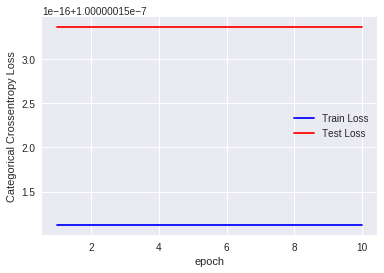

In [62]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])
nb_epoch =10
import matplotlib.pyplot as plt
import numpy as np
import time
plt.plot(list(range(1,nb_epoch+1)), history.history['val_loss'], 'b', label="Train Loss")
plt.plot(list(range(1,nb_epoch+1)), history.history['loss'], 'r', label="Test Loss")
plt.legend()
plt.xlabel('epoch') ; plt.ylabel('Categorical Crossentropy Loss')

# Comparing both the models.

In [64]:
x = PrettyTable()
x.field_names = ["Model Number", "No of LSTM layers", "No of dense layers", "Optimizer", "Accuracy"]
x.add_row([1, 2, 2, "RMSProp", 1])
x.add_row([2, 2, 2, "ADAM", 1])
print(x)

+--------------+-------------------+--------------------+-----------+----------+
| Model Number | No of LSTM layers | No of dense layers | Optimizer | Accuracy |
+--------------+-------------------+--------------------+-----------+----------+
|      1       |         2         |         2          |  RMSProp  |    1     |
|      2       |         2         |         2          |    ADAM   |    1     |
+--------------+-------------------+--------------------+-----------+----------+


### Here I trained two different LSTM models on Amazon fine food reviews.

[1] Model 1 comprised of two LSTM layers with a dropout layer between them of value 0.2 and two dense layers with tanh and sigmoidal activation functions and with RMS prop optimizer and it gave an accuracy of 1.


[2] Model 2 comprised of two LSTM with two LSTM layers with 100 units each and two dense layer with no dropout and adam optimizer and it gave an accuracy of 1.